# Setting up for pybind and w2.cpp file

In [ ]:
!rm -rf pybind_bfm
!git clone https://github.com/wonjunee/pybind_bfm
!pip install ./pybind_bfm

Cloning into 'pybind_bfm'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 96 (delta 42), reused 8 (delta 3), pack-reused 0
Unpacking objects: 100% (96/96), done.
Processing ./pybind_bfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for w2: filename=w2-0.0.1-cp37-cp37m-linux_x86_64.whl size=67488 sha256=717b6b684a9e0c29025e3bb92efb46db3fffd64df8fe1ffdee9279ee4c9daf97
  Stored in directory: /tmp/pip-ephem-wheel-cache-uv3c3ujj/wheels/59/df/ad/21d89dab3ad4cbb1acb68c8140bda27454aeecaa9b3f3fa06b
Successfully built w2
  Found existing installation: w2 0.0.1
    Uninstalling w2-0.0.1:
      Successfully uninstalled w2-0.0.1


In [ ]:
%matplotlib inline
import w2
from w2 import BFM
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import cv2

matplotlib.rcParams['figure.figsize'] = (8, 8)
matplotlib.rcParams['image.cmap'] = 'cividis'

np.set_printoptions(precision=4)

print("Imported!")

Imported!


## Accessory functions

In [ ]:
from scipy.fftpack import fft, dct, idct, dctn, idctn

# initialization of variables
def initialize_variables(n1, n2):
    x,y = np.meshgrid(np.linspace(0.5/n1,1-0.5/n1,n1), np.linspace(0.5/n2,1-0.5/n1,n2))
    phi = 0.5 * (x*x + y*y)
    psi = 0.5 * (x*x + y*y)

    # kernel for an inverse laplacian
    xx, yy = np.meshgrid(np.linspace(0,np.pi,n1,False), np.linspace(0,np.pi,n2,False))
    kernel = 2*n1*n1*(1-np.cos(xx)) + 2*n2*n2*(1-np.cos(yy))

    return x,y,phi,psi,kernel

# 2d DCT
def dct2(a):
    return dctn(a, norm='ortho')
    
# 2d IDCT
def idct2(a):
    return idctn(a, norm='ortho')

# one step of H1 gradient accent
def update_potential(phi, rho, nu, sigma, n1, n2):
    rho -= nu
    workspace = dct2(rho) / kernel
    workspace[0,0] = 0
    workspace = idct2(workspace)
    
    phi += sigma * workspace
    h1 = np.sum(workspace * rho) / (n1*n2)
    
    return phi, h1

# Compute dual value
def compute_w2(phi, psi, mu, nu, x, y):
    n1,n2 = mu.shape
    return np.sum(0.5 * (x*x+y*y) * (mu + nu) - nu*phi - mu*psi)/(n1*n2)

# parameters for Goldstein scheme
scaleDown = 0.8
scaleUp   = 1/scaleDown
upper = 0.75
lower = 0.25

# Goldstein scheme for updating a step size sigma
def step_update(sigma, value, oldValue, gradSq):
    diff = value - oldValue

    if diff > gradSq * sigma * upper:
        return sigma * scaleUp
    elif diff < gradSq * sigma * lower:
        return sigma * scaleDown
    return sigma


# Parameters

In [ ]:
# Grid sizes
n1 = 64 # x axis
n2 = 64 # y axis

# Maximum iterations for BFM
maxIters = 100

# Initial step size
sigma = 0.1

# Initialize mu and nu

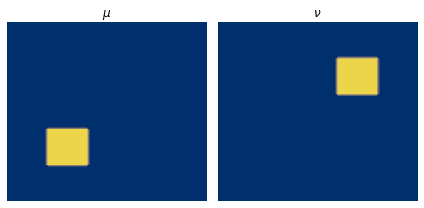

In [ ]:
mu = np.zeros((n2,n1))
nu = np.zeros((n2,n1))

x,y,phi,psi,kernel = initialize_variables(n1,n2)

mu[(np.abs(x-0.3) < 0.1) & (np.abs(y-0.3) < 0.1)] = 1
nu[(np.abs(x-0.7) < 0.1) & (np.abs(y-0.7) < 0.1)] = 1

mu *= n1*n2 / np.sum(mu)
nu *= n1*n2 / np.sum(nu)

fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].contourf(mu)
ax[0].set_title("$\\mu$")
ax[0].axis("off")
ax[1].contourf(nu)
ax[1].set_title("$\\nu$")
ax[1].axis("off")
plt.tight_layout()
plt.show()

# Run BFM

## Run BFM

In [ ]:
bfm = BFM(n1,n2,mu)

oldValue = compute_w2(phi, psi, mu, nu, x, y)

numDigitsIter=np.floor(np.log10(maxIters) + 1)

value = 0

rho = np.copy(mu)

gradSq = 1

for i in range(maxIters+1):
        
    phi, gradSq=update_potential(phi, rho, nu, sigma, n1, n2);

    bfm.compute_2d_dual(psi, phi)
    bfm.compute_2d_dual(phi, psi)

    value=compute_w2(phi, psi, mu, nu, x, y);
    sigma=step_update(sigma, value, oldValue, gradSq)

    oldValue=value;

    bfm.pushforward(rho, phi, nu);

    psi, gradSq=update_potential(psi, rho, mu, sigma, n1, n2);

    bfm.compute_2d_dual(phi, psi)
    bfm.compute_2d_dual(psi, phi)

    bfm.pushforward(rho, psi, mu);

    value=compute_w2(phi, psi, mu, nu, x, y);
    
    sigma=step_update(sigma, value, oldValue, gradSq)

    oldValue=value;

    sigma=np.maximum(sigma,.05);

    if i % 5 == 0:
        print(f'iter {i:5d}, W2 value: {value:4.4e}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


iter     0, W2 value: 1.2218e-01
iter     5, W2 value: 1.5259e-01
iter    10, W2 value: 1.5259e-01
iter    15, W2 value: 1.5259e-01
iter    20, W2 value: 1.5259e-01
iter    25, W2 value: 1.5259e-01
iter    30, W2 value: 1.5259e-01
iter    35, W2 value: 1.5259e-01
iter    40, W2 value: 1.5259e-01
iter    45, W2 value: 1.5259e-01
iter    50, W2 value: 1.5259e-01
iter    55, W2 value: 1.5259e-01
iter    60, W2 value: 1.5259e-01
iter    65, W2 value: 1.5259e-01
iter    70, W2 value: 1.5259e-01
iter    75, W2 value: 1.5259e-01
iter    80, W2 value: 1.5259e-01
iter    85, W2 value: 1.5259e-01
iter    90, W2 value: 1.5259e-01
iter    95, W2 value: 1.5259e-01
iter   100, W2 value: 1.5259e-01


# Plotting the result

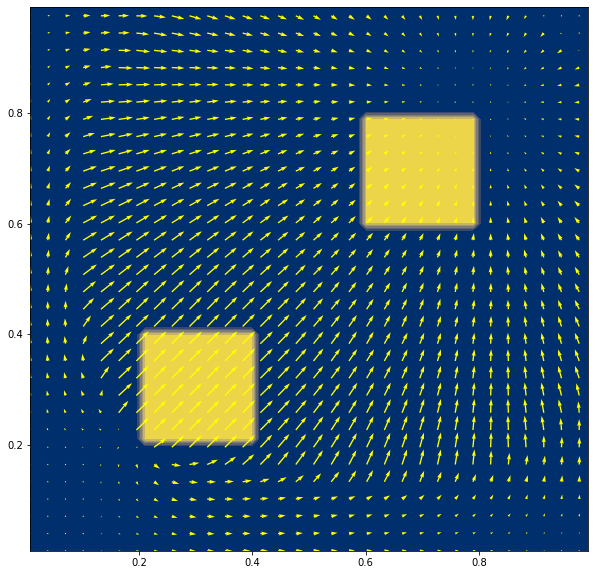

In [ ]:
my, mx = np.gradient(psi - 0.5*(x*x+y*y))

s = 2
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.contourf(x,y,(mu+nu))
ax.quiver(x[::s,::s], y[::s,::s], mx[::s,::s], my[::s,::s], color='yellow')

plt.show()

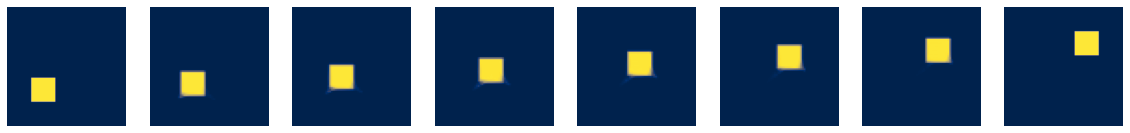

In [ ]:
n_fig = 8
fig, ax = plt.subplots(1, n_fig,figsize=(20,10))

ax[0].imshow(np.flipud(mu))
ax[0].axis("off")
ax[n_fig-1].imshow(np.flipud(nu))
ax[n_fig-1].axis("off")

interpolate = np.zeros_like(rho)

for i in range(1,n_fig-1):
    t = 1.0 * i / (n_fig - 1)
    psi_tmp = 0.5 * (x*x + y*y) - t * (0.5 * (x*x + y*y) - psi)
    phi_tmp = 0.5 * (x*x + y*y) - (1-t) * (0.5 * (x*x + y*y) - phi)

    bfm.pushforward(rho, psi_tmp, mu);
    interpolate = np.copy(rho)

    bfm.pushforward(rho, phi_tmp, nu);
    interpolate = (1-t) * interpolate + t * rho
    ax[i].imshow(np.flipud(interpolate))
    ax[i].axis("off")

plt.show()

## Different example

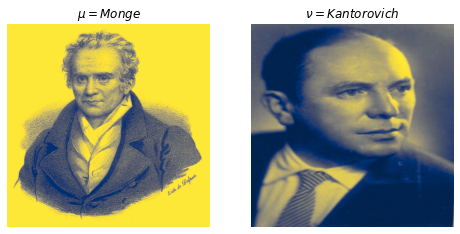

In [ ]:
## Setup the initial parameters

# Grid sizes
n1 = 512 # x axis
n2 = 512 # y axis

# Maximum iterations for BFM
maxIters = 40

# Initial step size
sigma = 0.1

## initialize input data mu and nu

mu = plt.imread("./pybind_bfm/images/monge.jpg")
mu = cv2.cvtColor(mu, cv2.COLOR_BGR2GRAY)
mu = mu.astype('float64')
nu = plt.imread("./pybind_bfm/images/kanto.jpg")
nu = nu.astype('float64')

mu = cv2.resize(mu, (n2,n1))
nu = cv2.resize(nu, (n2,n1))

mu *= n1*n2 / np.sum(mu)
nu *= n1*n2 / np.sum(nu)

fig, ax = plt.subplots(1,2)
ax[0].imshow(mu)
ax[0].set_title("$\\mu = Monge$")
ax[0].axis("off")
ax[1].imshow(nu)
ax[1].set_title("$\\nu = Kantorovich$")
ax[1].axis("off")
plt.show()

In [ ]:
## Running BFM

# initialize BFM
bfm = BFM(n1,n2,mu)

# initialize variables for BFM
x,y,phi,psi,kernel = initialize_variables(n1,n2)

oldValue = compute_w2(phi, psi, mu, nu, x, y)

numDigitsIter=np.floor(np.log10(maxIters) + 1)

value = 0

rho = np.copy(mu)

gradSq = 1

for i in range(maxIters+1):
        
    phi, gradSq=update_potential(phi, rho, nu, sigma, n1, n2);
    bfm.compute_2d_dual(psi, phi)
    bfm.compute_2d_dual(phi, psi)
    value=compute_w2(phi, psi, mu, nu, x, y);
    sigma=step_update(sigma, value, oldValue, gradSq);

    oldValue=value;

    bfm.pushforward(rho, phi, nu);
    psi, gradSq=update_potential(psi, rho, mu, sigma, n1, n2);
    bfm.compute_2d_dual(phi, psi)
    bfm.compute_2d_dual(psi, phi)
    bfm.pushforward(rho, psi, mu);
    value=compute_w2(phi, psi, mu, nu, x, y);
    sigma=step_update(sigma, value, oldValue, gradSq);

    oldValue=value;

    sigma=np.maximum(sigma,.05);

    if i % 5 == 0:
        print(f'iter {i:5d}, W2 value: {value:4.4e}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


iter     0, W2 value: 2.8820e-03
iter     5, W2 value: 8.4509e-03
iter    10, W2 value: 8.4665e-03
iter    15, W2 value: 8.4670e-03
iter    20, W2 value: 8.4671e-03
iter    25, W2 value: 8.4672e-03
iter    30, W2 value: 8.4673e-03
iter    35, W2 value: 8.4674e-03
iter    40, W2 value: 8.4674e-03


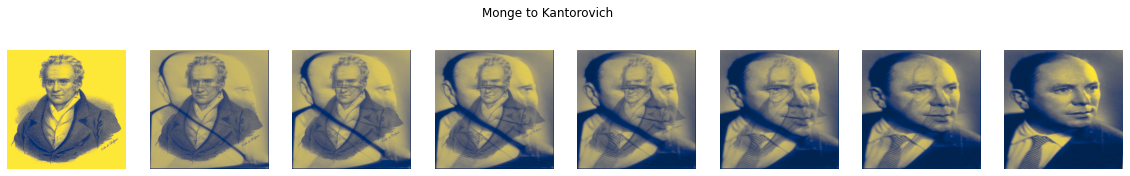

In [ ]:
## Interpolation

n_fig = 8
fig, ax = plt.subplots(1, n_fig,figsize=(20,3))

ax[0].imshow(mu)
ax[0].axis("off")
ax[n_fig-1].imshow(nu)
ax[n_fig-1].axis("off")

interpolate = np.zeros_like(rho)

for i in range(1,n_fig-1):
    t = 1.0 * i / (n_fig - 1)
    psi_tmp = 0.5 * (x*x + y*y) - t * (0.5 * (x*x + y*y) - psi)
    phi_tmp = 0.5 * (x*x + y*y) - (1-t) * (0.5 * (x*x + y*y) - phi)

    bfm.pushforward(rho, psi_tmp, mu);
    interpolate = np.copy(rho)

    bfm.pushforward(rho, phi_tmp, nu);
    interpolate = (1-t) * interpolate + t * rho
    ax[i].imshow(interpolate)
    ax[i].axis("off")

plt.suptitle("Monge to Kantorovich")
plt.show()